# FCC Calorimeter Performance Studies Workflow

## Overview

This tutorial will teach you how to:

* **simulate** the single particle response of the calorimeter detector system
* **reconstruct** physics object from raw signals
* produce **plots** of energy resolutions and other quantities.

First, make sure your setup of the FCC software is working. 
You can check that the command to run jobs in the Gaudi framework is available on the command line:

In [1]:
!which fccrun

/cvmfs/fcc.cern.ch/sw/releases/fccsw/linux-centos7-x86_64/gcc-8.3.0/fccsw-0.11-qqmlmzumogldsqoegt4ihhel4xnt62yw/scripts/fccrun


If you don't see a valid path like `/usr/local/bin/fccrun`  you should consult [the documentation page on FCCSW setup](https://github.com/vvolkl/fcc-tutorials/blob/master/FccSoftwareGettingStarted.md)

## Using the DD4hep detector model in FCC Software.

The Geant4 geometry is used for the full simulation of the detector is not written directly, but generated using the DD4hep library.
The detector description in this library consists of two parts:
A compiled C++ library that constructs the geometry, and a set of xml files that contain parameters that can are parsed by the library at runtime and make the detector geometry (somewhat) configurable.
In the framework, the geometry is available to all components via the service `GeoSvc`.
One of the simplest jobs is to write the geometry to a `.gdml` file:

In [8]:
%%writefile dumpGeo_fccee.py

import os
from Gaudi.Configuration import *
from Configurables import GeoSvc
geoservice = GeoSvc("GeoSvc")
geoservice.detectors=[
  os.path.join(os.environ.get("FCC_DETECTORS", ""), 'share/FCCSW/Detector/DetFCCeeIDEA/compact/FCCee_DectMaster.xml'),
                    ]

from Configurables import SimG4Svc
geantservice = SimG4Svc("SimG4Svc")

from Configurables import GeoToGdmlDumpSvc
geodumpservice = GeoToGdmlDumpSvc("GeoDump") 
geodumpservice.gdml="FCCee_IDEA.gdml"

from Configurables import ApplicationMgr
ApplicationMgr( TopAlg = [], 
                EvtSel = 'NONE',
                EvtMax   = 1,
                # order is important, as GeoSvc is needed by SimG4Svc
                ExtSvc = [geoservice, geantservice, geodumpservice],
                OutputLevel=INFO
 )


Overwriting dumpGeo_fccee.py


A job with this configuration can be executed with 

In [9]:
!fccrun dumpGeo_fccee.py

 

ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v32r0)
                                          running on 12095b4ff1c8 on Wed Sep 25 14:34:02 2019

**************************************************************
 Geant4 version Name: geant4-10-05-patch-01 [MT]   (17-April-2019)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

ApplicationMgr       INFO Application Manager Configured successfully
PersistencyIO    INFO  +++ Set Streamer to dd4hep::OpaqueDataBlock
GeoSvc               INFO loading geometry from file:  '/cvmfs/fcc.cern.ch/sw/releases/fccsw/linux-centos7-x86_64/gcc-8.3.0/fccsw-0.11-qqmlmzumogldsqoe

RndmGenSvc.Engine    INFO Generator engine type:CLHEP::RanluxEngine
RndmGenSvc.Engine    INFO Current Seed:1234567 Luxury:3
RndmGenSvc           INFO Using Random engine:HepRndm::Engine<CLHEP::RanluxEngine>
<<< Geant4 Physics List simulation engine: FTFP_BERT 2.0

Geant4Converter  INFO  +++  Successfully converted geometry to Geant4.
DD4hepVolumeManager INFO  **** running plugin DD4hepVolumeManager ! 
VolumeManager    INFO   - populating volume ids - be patient ...
VolumeManager    INFO   - populating volume ids - done. 348 nodes.
VolumeManager    INFO  +++ Volume manager populated and loaded.

 FTFP_BERT : new threshold between BERT and FTFP is over the interval 
 for pions :   3 to 12 GeV
 for kaons :   3 to 12 GeV
 for proton :  3 to 12 GeV
 for neutron : 3 to 12 GeV

### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0
even though it appears in the current tracking world.
Default cuts are used for this region.
even though it appears in the current tracking

Note the printout of the GeoSvc and make sure the information is as expected. If there is something unclear or missing make sure to open an [issue](https://github.com/HEP-FCC/FCCSW/issues)!
Take a look at the resulting gdml file. Although it is text-based it is not really human-readable for a geometry of this size, but you can check the number of lines and volume names if you are familiar with the geometry.

In [10]:
!tail FCCee_IDEA.gdml

        <volumeref ref="LumiCalBackShield_envelope0x45efb70"/>
      </physvol>
    </volume>
  </structure>

  <setup name="Default" version="1.0">
    <world ref="world_volume0x45efd40"/>
  </setup>

</gdml>


In [11]:
# count occurences of "physvol"
!grep -c "<physvol" FCCee_IDEA.gdml

717


## Running Geant4 within the FCC Software Framework

To run Geant4, a number of additional components are required, foremost the `SimG4Alg` and `SimG4Svc`.
The simplest way to generate a particle to simulate is to use one of the particle guns (`GenAlg` with the `MomentumRangeParticleGun` tool for example).
This algorithm produces a particles with energies from a flat probability distribution in HepMC format.
To use them as input they first need to be converted to the FCC event data model (`HepMCToEDMConverter`) and piped into the Geant4 interface via the `SimG4PrimariesFromEdmTool`.

A configuration that runs all of this is distributed with FCCSW and can be run with the following command:

(This simulates the response of 5GeV electrons which makes for modest shower sizes and should produce 500 events in around 2 minutes)


In [20]:
! FCC_DETECTORS=$FCCSWBASEDIR/share/FCCSW; time fccrun  $FCCSWBASEDIR/share/FCCSW/RecFCCeeCalorimeter/options/runCaloSim.py --filename fccee_idea_LAr_pgun.root -n 500 

 -->  SimG4Alg  -->  CreateECalBarrelCellsStep1  -->  positionsBarrelEcal  -->  ReSegmentationEcal  -->  CreateECalBarrelCells  -->  out  

ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v32r0)
                                          running on 12095b4ff1c8 on Wed Sep 25 14:42:53 2019

**************************************************************
 Geant4 version Name: geant4-10-05-patch-01 [MT]   (17-April-2019)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

ApplicationMgr       INFO Application Manager Configured successfully
GeoSvc               INFO loading geometry from file:  '/cvmfs/fcc.cern.ch/sw/rel

EventLoopMgr      WARNING Unable to locate service "EventSelector" 
EventLoopMgr      WARNING No events will be processed from external input.
HistogramPersis...WARNING Histograms saving not required.
ApplicationMgr       INFO Application Manager Initialized successfully
ApplicationMgr       INFO Application Manager Started successfully
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.122372 4.25562
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.125598 2.70235
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0794692 3.87968
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.225321 6.07226
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.083957 0.640604
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.277845 5.52364
SimG4Alg.SimG4S...  DEB

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.187878 5.56297
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.153536 4.37144
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.272557 3.40854
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.289929 4.46909
SimG4Alg.SimG4S...  DEBUG p

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.169768 2.38379
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.286259 4.79341
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.246794 3.35465
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.215956 1.25576
SimG4Alg.SimG4S...  DEBUG p

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.14393 2.64802
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.138963 4.81843
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.272119 4.06559
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.134043 5.8937
SimG4Alg.SimG4S...  DEBUG p

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.172827 1.25823
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0434015 5.4157
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.225354 3.26357
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.172216 6.16221
SimG4Alg.SimG4S...  DEBUG

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.121666 5.28339
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.126467 4.87918
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.248011 3.28321
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.274537 3.50137
SimG4Alg.SimG4S...  DEBUG p

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.290366 1.28264
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0658018 5.98521
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.00807446 0.482792
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0316183 5.99226
SimG4Alg.SimG4S...  DE

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0622104 1.81148
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.077267 4.39751
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.227947 2.2017
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0170014 5.4272
SimG4Alg.SimG4S...  DEBUG p

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.188341 3.72581
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.103173 4.49678
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0109495 4.91314
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.274798 1.00924
SimG4Alg.SimG4S...  DEBUG

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0754434 5.14374
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.226424 1.43137
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.21453 5.78045
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.176076 2.60524
SimG4Alg.SimG4S...  DEBUG p

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.172038 2.54011
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.00754142 5.45019
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.183447 4.47673
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.00769669 1.57774
SimG4Alg.SimG4S...  DEB

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.180477 2.62608
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0015978 0.451291
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.043758 0.19163
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0551516 4.3199
SimG4Alg.SimG4S...  DEBU

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.117319 3.58189
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.258826 3.8828
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0147956 5.41121
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.260726 0.252286
SimG4Alg.SimG4S...  DEBUG 

SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0842279 0.360714
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0285618 2.89385
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.275828 0.850252
SimG4Alg.SimG4S...  DEBUG particle definition 0x49b8740 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.249638 0.182766
SimG4Alg.SimG4S...  

WARNING - Attempt to delete the region store while geometry closed !

real	3m1.357s
user	2m55.667s
sys	0m1.605s


The output of this job is `fccee_idea_LAr_pgun.root`, a ROOT file containing the simulation products of 500 single particle events (5 Gev e-) in the FCC event data model.
Check for example that the distribution of the input particles is as you expect:

Welcome to JupyROOT 6.18/04


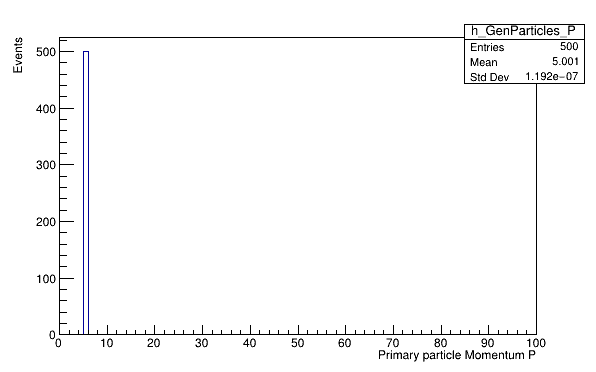

In [21]:
import ROOT
f = ROOT.TFile("fccee_idea_LAr_pgun.root")
events = f.Get("events")
c = ROOT.TCanvas("canvas1", "",600, 400)
h = ROOT.TH1F("h_GenParticles_P", ";Primary particle Momentum P; Events", 100, 0 ,100)
events.Draw("sqrt(pow(GenParticles.core.p4.px,2) + pow(GenParticles.core.p4.py,2) +pow(GenParticles.core.p4.pz,2))>>h_GenParticles_P")
c.Draw()


The exact position of the energy deposit is available too (Note that this collection, which is MCTruth-level information is not usually saved on disk to save space):

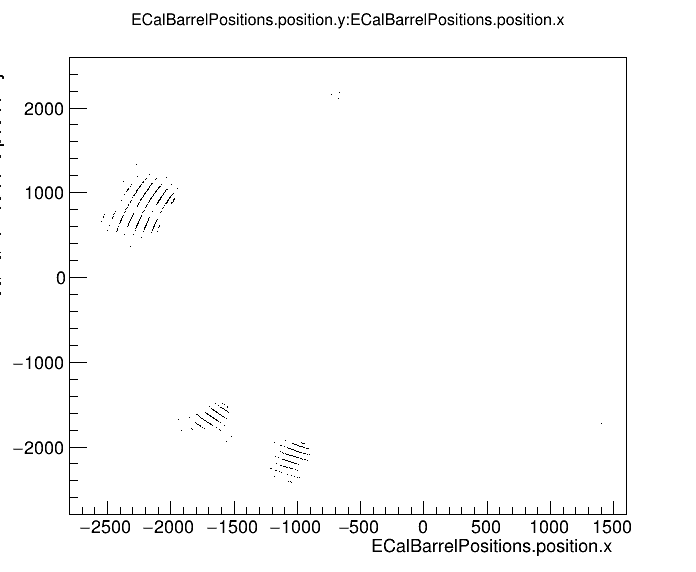

In [22]:
import ROOT
f = ROOT.TFile("fccee_idea_LAr_pgun.root")
events = f.Get("events")

c = ROOT.TCanvas("c_ECalBarrelPositions_xy", "", 700, 600)
# draw hits for first five events
events.Draw("ECalBarrelPositions.position.y:ECalBarrelPositions.position.x", "", "", 5, 0)
c.Draw()

### Obtaining and Plotting the Energy Resolution

Now that the detector response is simulated, it is time to reconstruct the signals. FCCSW includes another configuration to run a Sliding Window reconstruction:

In [32]:
!FCC_DETECTORS=$FCCSWBASEDIR/share/FCCSW; fccrun $FCCSWBASEDIR/share/FCCSW/RecFCCeeCalorimeter/options/runFullCaloSystem_ReconstructionSW_noiseFromFile.py -v --input fccee_idea_LAr_pgun.root -n 100 --noiseFileName root://eospublic.cern.ch//eos/experiment/fcc/ee/simulation/NoiseConstants/elecNoise_ecalBarrelFCCee_50Ohm_traces1_4shieldWidth.root --filename output_allCalo_reco_noise.root

 -->  PodioReader  -->  CreateEmptyCaloCells  -->  CreateECalBarrelCells  -->  CreateClusters  -->  out  

ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v32r0)
                                          running on 12095b4ff1c8 on Wed Sep 25 15:21:28 2019
ApplicationMgr       INFO Application Manager Configured successfully
GeoSvc               INFO loading geometry from file:  '/cvmfs/fcc.cern.ch/sw/releases/fccsw/linux-centos7-x86_64/gcc-8.3.0/fccsw-0.11-qqmlmzumogldsqoegt4ihhel4xnt62yw/share/FCCSW/Detector/DetFCCeeIDEA-LAr/compact/FCCee_DectEmptyMaster.xml'
Detector         WARN  +++ Object 'GlobalTrackerReadoutID' is already defined and new one will be ignored
GeoSvc               INFO loading geometry from file:  '/cvmfs/fcc.cern.ch/sw/releases/fccsw/linux-centos7-x86_64/gcc-8.3.0/fccsw-0.11-qqmlmzumogldsqoegt4ihhel4xnt62yw/share/FCCSW/Detector/DetFCCeeECalInclined/compact/FCCee_ECalBarrel_withCryostat.xml'
ECal

This configuration inludes electronics noise especially calculated for this detector geometry. which is overlayed on the branch `ECalBarrelCells` containing information on all cells in the ECal Barrel.
First, let's visualize the impact of the noise:

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_ECalBarrelCellsNoise_energy


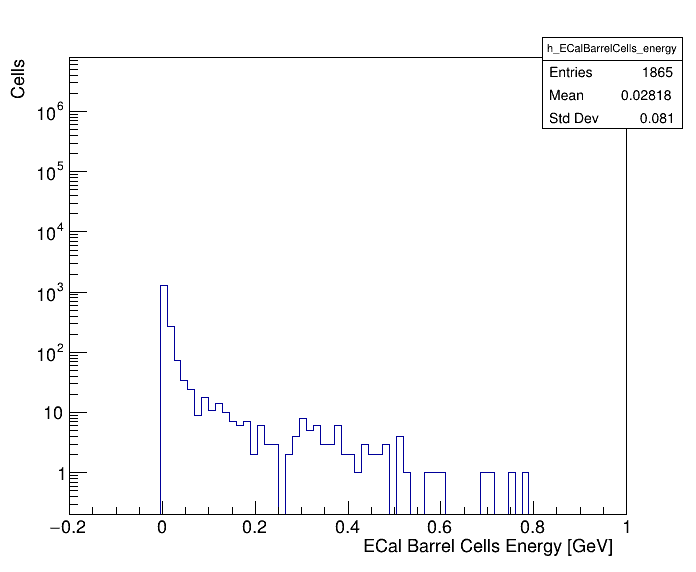

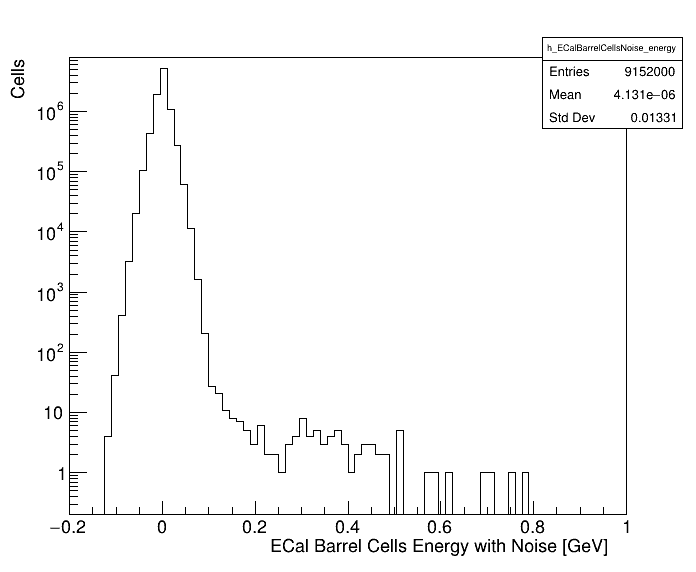

In [29]:
import ROOT
f = ROOT.TFile("output_allCalo_reco_noise.root")
events = f.Get("events")

c = ROOT.TCanvas("c_ECalBarrelCellsNoise_energy", "", 700, 600)

h = ROOT.TH1F("h_ECalBarrelCells_energy", ";ECal Barrel Cells Energy [GeV]; Cells", 80, -0.2 ,1)
events.Draw("ECalBarrelCells.core.energy >> h_ECalBarrelCells_energy", "", "", 10, 0)
h.GetYaxis().SetRangeUser(0.2, 8*10**6)



c.SetLogy()
c.Draw()

c2 = ROOT.TCanvas("c_ECalBarrelCells_energy", "", 700, 600)
#h2 = ROOT.TH1F("h_ECalBarrelCellsNoise_energy", ";ECall Barrel Cells Energy with Noise [GeV]; Events", 80, -0.2 ,1)
h2 = h.Clone("h_ECalBarrelCellsNoise_energy")
h2.SetTitle(";ECal Barrel Cells Energy with Noise [GeV]; Cells")
events.Draw("ECalBarrelCellsNoise.core.energy>> h_ECalBarrelCellsNoise_energy", "", "", 10, 0)
h2.GetYaxis().SetRangeUser(0.2, 8*10**6)
h2.SetLineColor(ROOT.kBlack)


c2.SetLogy()
c2.Draw()

From these plots the impact of the noise becomes clear. Note that the branch `EcalBarrelCellsNoise` is much larger than `ECalBarrelCells`, as all cells that did not record a signal can no longer be ignored, but have to be saved as well due to the presence of noise.

### Extracting and Plotting the Resolution

The root file created by FCCSW also contains the output of the Sliding Window reconstruction in the branch "CaloClusters". Again, we first check the contents:

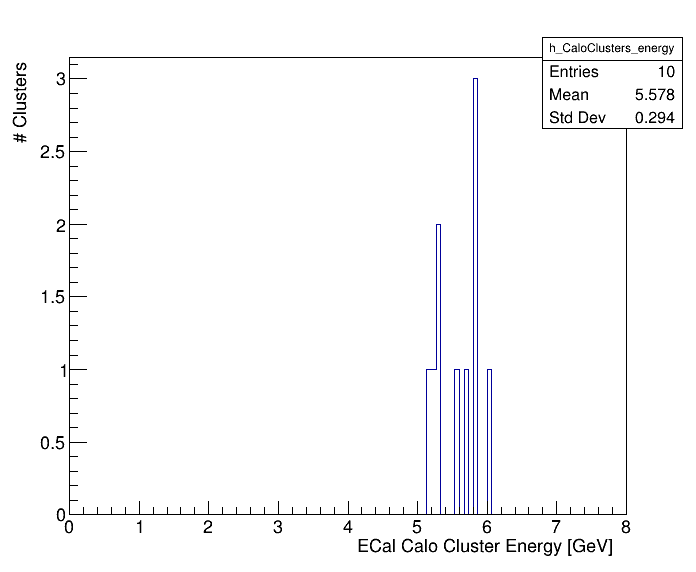

In [30]:
import ROOT
f = ROOT.TFile("output_allCalo_reco_noise.root")
events = f.Get("events")

c = ROOT.TCanvas("c_CaloClusters_energy", "", 700, 600)
hEn = ROOT.TH1F("h_CaloClusters_energy", ";ECal Calo Cluster Energy [GeV]; # Clusters", 120, 0 ,8)
events.Draw("CaloClusters.core.energy >> h_CaloClusters_energy")

c.Draw()


To extract the Calorimeter Performance, we have to fit the reco energy distribution:

mean: 5.67 [GeV]
sigma: 0.85 [GeV]


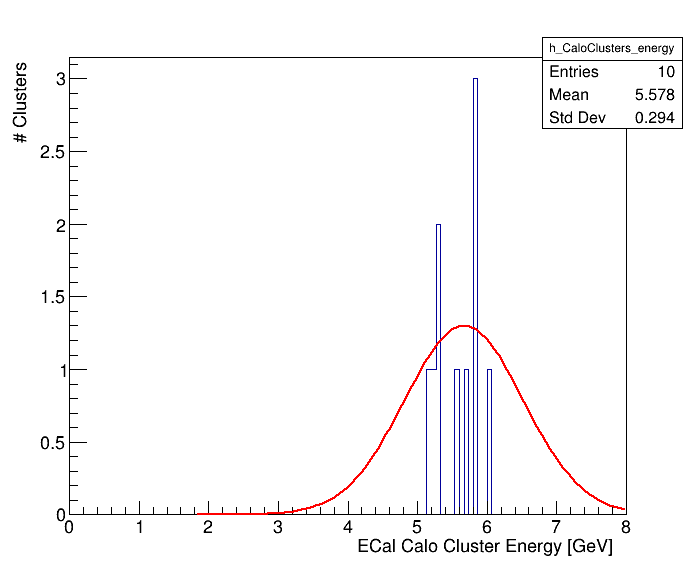

In [31]:

import ROOT
f = ROOT.TFile("output_allCalo_reco_noise.root")
events = f.Get("events")

c = ROOT.TCanvas("c_CaloClusters_energyFit", "", 700, 600)
hEn = ROOT.TH1F("h_CaloClusters_energy", ";ECal Calo Cluster Energy [GeV]; # Clusters", 120, 0 ,8)
events.Draw("CaloClusters.core.energy >> h_CaloClusters_energy")

fitPre = ROOT.TF1("fitPre","gaus", hEn.GetMean() - 1. * hEn.GetRMS(), hEn.GetMean() + 1. * hEn.GetRMS())
resultPre = hEn.Fit(fitPre, "SQRN")
fit = ROOT.TF1("fit","gaus", resultPre.Get().Parameter(1) - 2. * resultPre.Get().Parameter(2), resultPre.Get().Parameter(1) + 2. * resultPre.Get().Parameter(2))
result = hEn.Fit(fit, "SQRN")
mean = result.Get().Parameter(1)
sigma = result.Get().Parameter(2)
dMean = result.Get().Error(1)
dSigma = result.Get().Error(2)
print "mean:", round(mean,2), "[GeV]"
print "sigma:", round(sigma  ,2), "[GeV]"
fit.Draw("SAME")
c.Draw()



### Further Topics: Parametrizing the Energy Resolution 

We are of course interested in the Calorimeter response not only at one energy, but over a range of energies,
and in particular in the usual parametrisation of the resolution:



$$  {\sigma_E \over E} =  { a \over \sqrt{E}} \oplus  {b \over E} \oplus c  $$,

where a is the "stochastic term", b the "noise term" and c the "constant term" 

This requires a somewhat more complex script. The FCC Calo Group maintains one here: https://github.com/faltovaj/FCC_calo_analysis_cpp/blob/master/scripts/plot_enResolution.py

TODO: Install a modified version of this script that can run on pre-produced samples on eos?




### Further Topics: Calculating the Sampling Fraction and using it in Simulation

As you can see in https://github.com/HEP-FCC/FCCSW/blob/master/Reconstruction/RecFCCeeCalorimeter/options/runCaloSim.py#L112, the simulation already corrected for the sampling fraction of our calorimeter.
These values themselves are taken from simulation and in case you change the geometry they need to be recalculated and updated.

TODO: This will be part of another tutorial. Add link.